# **Rating product & sorting reviews in amazon**

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.expand_frame_repr', False)

### reding the dataset

In [2]:
df = pd.read_csv('../input/amazon-review-rating-product-sorting-review/amazon_review.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


### business problem

One of the most important problems in e-commerce is the correct calculation of the points given to the products after sales.The solution to this problem means providing greater customer satisfaction for the e-commerce site, prominence of the product for the sellers and a seamless shopping experience for the buyers.Another problem is the correct ordering of the comments given to the products.Since misleading comments will directly affect the sale of the product, it will cause both financial loss and loss of customers.In the solution of these 2 basic problems, e-commerce site and sellers will increase their sales, while customers will complete their purchasing journey without any problems.

### dataset story
This dataset, which includes Amazon product data, includes product categories and various metadata.
The product with the most reviews in the electronics category has user ratings and reviews.

* reviewerID:     User ID
* asin:           Product ID
* reviewerName:   Username
* helpful:        Helpful rating rating
* reviewText:     Review
* overall:        Product rating
* summary:        Evaluation summary
* unixReviewTime: Evaluation time
* reviewTime:     Reviewtime Raw
* day_diff:       Number of days since evaluation
* helpful_yes:    The number of times the review was found helpful
* total_vote:     Number of votes given to the review

### examining the dataframe

In [3]:
def check_dataframe(dataframe):
    print('####################################')
    print(dataframe.head())
    print('####################################')
    print(dataframe.tail())
    print('####################################')
    print(dataframe.shape)
    print('####################################')
    print(dataframe.columns)
    print('####################################')
    print(dataframe.info())
    print('####################################')
    print(dataframe.isnull().values.any())
    print('####################################')
    print(dataframe.isnull().sum())
    print('####################################')
    print(dataframe.nunique())
    print('####################################')
    print(dataframe.describe([0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

check_dataframe(df)

####################################
       reviewerID        asin  reviewerName helpful                                         reviewText  overall                                 summary  unixReviewTime  reviewTime  day_diff  helpful_yes  total_vote
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]                                         No issues.     4.00                              Four Stars      1406073600  2014-07-23       138            0           0
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]  Purchased this for my device, it worked as adv...     5.00                           MOAR SPACE!!!      1382659200  2013-10-25       409            0           0
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]  it works as expected. I should have sprung for...     4.00               nothing to really say....      1356220800  2012-12-23       715            0           0
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]  This think has worked out great.Had a diff. br... 

### catching the categorical, numerical and cardinal variables

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # categorical variable
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numerical variables
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # reposrting section
    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # keeping the calculated values
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 4915
Variables: 12
cat_cols: 2
num_cols: 4
cat_but_car: 6
num_but_cat: 1


In [5]:
cat_cols

['asin', 'overall']

In [6]:
# since overall is our target, it was removed from the cat_cols
cat_cols = [col for col in cat_cols if 'overall' not in col]
cat_cols

['asin']

In [7]:
num_cols

['unixReviewTime', 'day_diff', 'helpful_yes', 'total_vote']

In [8]:
cat_but_car

['reviewerID',
 'reviewerName',
 'helpful',
 'reviewText',
 'summary',
 'reviewTime']

#### summary of categorical variables


 ########## ASIN ##########
            ASIN  RATIO (%)
B007WTAJTO  4915     100.00


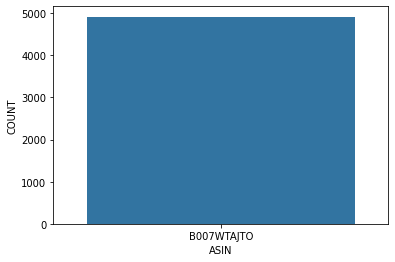

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print('\n', '#' * 10, col_name.upper(), 10 * '#')
    print(pd.DataFrame({
        col_name.upper(): dataframe[col_name].value_counts(),
        'RATIO (%)': round(100 * (dataframe[col_name].value_counts() / len(dataframe)), 2)
    }))

    if plot:
        sns.countplot(x=dataframe[col_name])
        plt.ylabel('COUNT')
        plt.xlabel(col_name.upper())
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

#### summary of numerical columns


 ########## UNIXREVIEWTIME ##########
       UNIXREVIEWTIME
count         4915.00
mean    1379465001.67
std       15818574.32
min     1339200000.00
25%     1365897600.00
50%     1381276800.00
75%     1392163200.00
max     1406073600.00


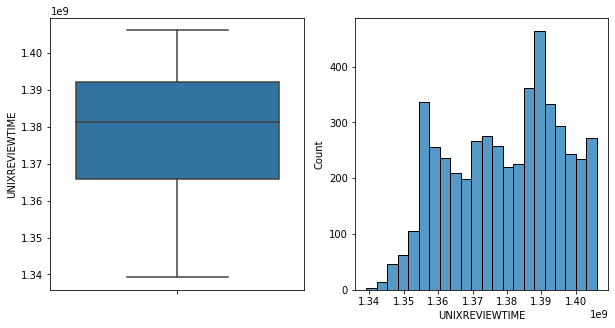


 ########## DAY_DIFF ##########
       DAY_DIFF
count   4915.00
mean     437.37
std      209.44
min        1.00
25%      281.00
50%      431.00
75%      601.00
max     1064.00


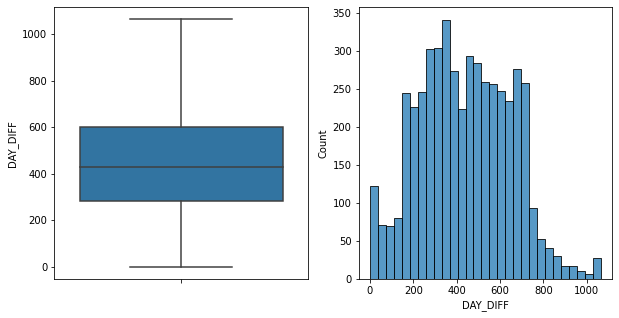


 ########## HELPFUL_YES ##########
       HELPFUL_YES
count      4915.00
mean          1.31
std          41.62
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        1952.00


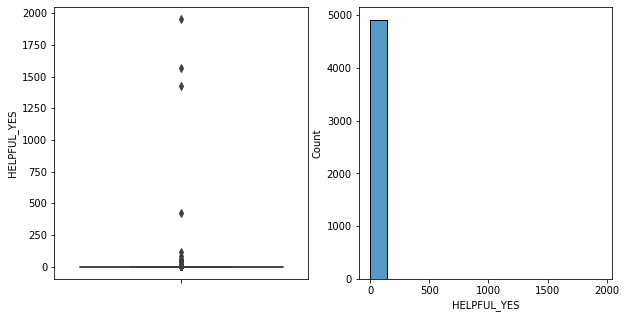


 ########## TOTAL_VOTE ##########
       TOTAL_VOTE
count     4915.00
mean         1.52
std         44.12
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       2020.00


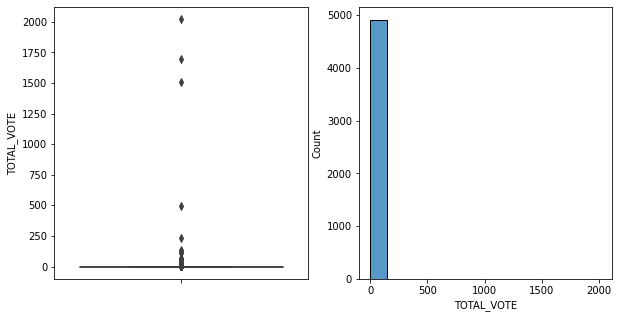

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    print('\n', '#' * 10, numerical_col.upper(), '#' * 10)
    print(pd.DataFrame({
        numerical_col.upper(): round(dataframe[numerical_col].describe().T, 2)
    }))

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=dataframe[numerical_col])
        plt.ylabel(numerical_col.upper())
        plt.subplot(1, 2, 2)
        sns.histplot(x=dataframe[numerical_col])
        plt.xlabel(numerical_col.upper())
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

#### analyzing the categorical columns with dependent variable


 ########## ASIN ##########
            TARGET_MEAN
asin                   
B007WTAJTO         4.59



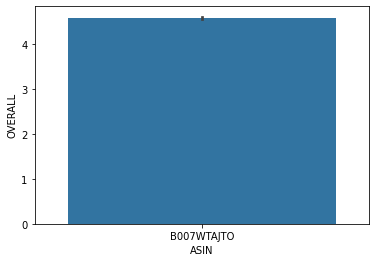

In [11]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print('\n', '#' * 10, categorical_col.upper(), '#' * 10)
    print(pd.DataFrame({
        'TARGET_MEAN': round(dataframe.groupby(categorical_col)[target].mean(), 2)
    }), end='\n\n')

    if plot:
        sns.barplot(x=dataframe[categorical_col], y=dataframe[target])
        plt.xlabel(categorical_col.upper())
        plt.ylabel(target.upper())
        plt.show(block=True)

for col in cat_cols:
    target_summary_with_cat(df, 'overall', col, plot=True)

#### analyzing the numerical columns with dependent variable

         unixReviewTime
overall                
1.00      1372115567.21
2.00      1377145800.00
3.00      1378789453.52
4.00      1379796851.61
5.00      1379949407.85



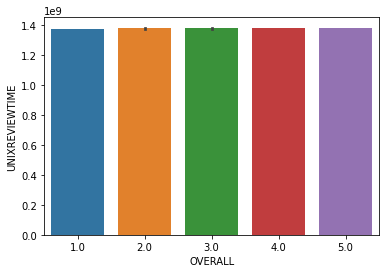

         day_diff
overall          
1.00       530.48
2.00       464.70
3.00       449.72
4.00       426.09
5.00       432.08



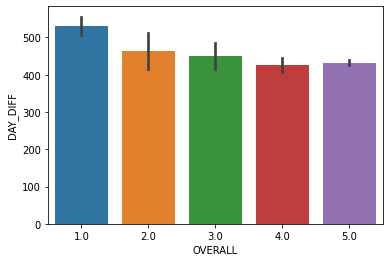

         helpful_yes
overall             
1.00            8.97
2.00            0.24
3.00            0.35
4.00            0.21
5.00            1.04



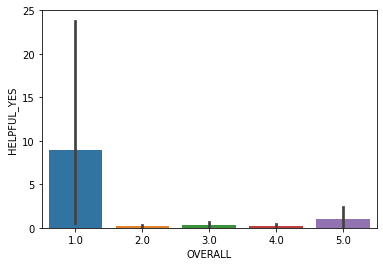

         total_vote
overall            
1.00          10.40
2.00           0.54
3.00           0.54
4.00           0.61
5.00           1.15



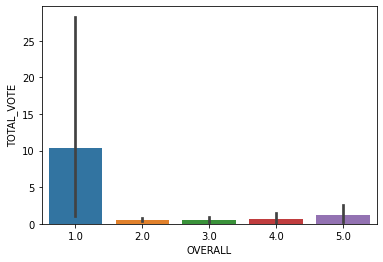

In [12]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")

    if plot:
        sns.barplot(x=dataframe[target], y=dataframe[numerical_col])
        plt.ylabel(numerical_col.upper())
        plt.xlabel(target.upper())
        plt.show(block=True)

for col in num_cols:
    target_summary_with_num(df, 'overall', col, plot=True)

### Task 1: Calculate the Average Rating according to the current comments and compare it with the existing average rating. In the shared data set, users gave points and comments to a product. Our aim in this task is to evaluate the scores given by weighting them by date. It is necessary to compare the first average score with the weighted score according to the date to be obtained.

#### Step 1: Calculate the average score of the product

In [13]:
df['overall'].mean()

4.587589013224822

#### Step 2: Calculate the weighted average score by date.
You need to declare the reviewTime variable as a date variable. Assume the max value of reviewTime as current_date you need to create a new variable by expressing the difference of each score-interpretation date and current_date in days, and divide the variable expressed in days by 4 with the quantile function (if 3 quarters are given, it will be 4 parts) and weight according to the values from the quartiles.For example, if q1 = 12, when weighting, averaging comments made less than 12 days ago and giving them a higher weight.

In [14]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
current_date = df['reviewTime'].max()
df['days'] = (current_date - df['reviewTime']).dt.days
df['days_cat'] = pd.qcut(df['days'], 4)
df['days_cat'].value_counts()

(-0.001, 280.0]    1236
(430.0, 600.0]     1228
(600.0, 1063.0]    1228
(280.0, 430.0]     1223
Name: days_cat, dtype: int64

In [15]:
def time_based_weighted_score(dataframe, w1=0.28, w2=0.26, w3=0.24, w4=0.22):
    return dataframe.loc[dataframe['days'] <= 280, 'overall'].mean() * w1 + dataframe.loc[
        (dataframe['days'] > 280) & (dataframe['days'] <= 430), 'overall'].mean() * w2 + dataframe.loc[
               (dataframe['days'] > 430) & (dataframe['days'] <= 600), 'overall'].mean() * w3 + dataframe.loc[
               (dataframe['days'] > 600), 'overall'].mean() * w4


time_based_weighted_score(df)

4.595593165128118

In [16]:
# when changing the weighted values
time_based_weighted_score(df, w1=0.40, w2=0.30, w3=0.20, w4=0.10) 

4.628116998159475

### Step 3: Compare and interpret the average of each time period in weighted scoring.

In [17]:
df.loc[df['days'] <= 280, 'overall'].mean()                         

4.6957928802588995

In [18]:
df.loc[(df['days'] > 280) & (df['days'] <= 430), 'overall'].mean()

4.636140637775961

In [19]:
df.loc[(df['days'] > 430) & (df['days'] <= 600), 'overall'].mean()

4.571661237785016

In [20]:
df.loc[(df['days'] > 600), 'overall'].mean()  

4.4462540716612375

### Task 2: Determine 20 reviews for the product to be displayed on the product detail page.

#### Step 1: Generate the helpful_no variable.
* total_vote is the total number of up-downs given to a comment.
* up means helpful.
* There is no helpful_no variable in the data set, it must be generated over existing variables.
* Find the number of votes that are not helpful (helpful_no) by subtracting the number of helpful
* votes (helpful_yes) from the total number of votes (total_vote).

In [21]:
df['helpful_no'] = df['total_vote'] - df['helpful_yes']

#### Step 2: Calculate score_pos_neg_diff, score_average_rating and wilson_lower_bound scores and add them to the data.
* To calculate score_pos_neg_diff, score_average_rating and wilson_lower_bound scores,
* define the score_pos_neg_diff, score_average_rating and wilson_lower_bound functions.
* Create scores based on score_pos_neg_diff. Next; Save it as score_pos_neg_diff in df.
* Create scores according to score_average_rating. Next; Save it as score_average_rating in df.
* Create scores according to wilson_lower_bound. Next; Save it as wilson_lower_bound in df.

In [22]:
# defingn the score_pos_neg_diff function
def score_pos_neg_diff(up, down):
    return up - down

# defining the score_average_rating function
def score_average_rating(up, down):
    if up + down == 0:
        return 0
    return up / (up + down)

# defining the wilson_lower_bound function
def wilson_lower_bound(up, down, confidence=0.95):
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

In [23]:
# creating the variable score_pos_nef_diff
df['score_pos_nef_diff'] = df.apply(lambda x: score_pos_neg_diff(x['helpful_yes'], x['helpful_no']), axis=1)

In [24]:
# creating the variable score_average_rating
df['score_average_rating'] = df.apply(lambda x: score_average_rating(x['helpful_yes'], x['helpful_no']), axis=1)

In [25]:
# creating the variable wilson_lower_bound
df['wilson_lower_bound'] = df.apply(lambda x: wilson_lower_bound(x['helpful_yes'], x['helpful_no']), axis=1)

In [26]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,days_cat,helpful_no,score_pos_nef_diff,score_average_rating,wilson_lower_bound
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0,137,"(-0.001, 280.0]",0,0,0.00,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,408,"(280.0, 430.0]",0,0,0.00,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,714,"(600.0, 1063.0]",0,0,0.00,0.00
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,381,"(280.0, 430.0]",0,0,0.00,0.00
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0,512,"(430.0, 600.0]",0,0,0.00,0.00


#### Step 3: Identify the 20 Interpretations and Interpret the results.
* Identify and rank the top 20 comments according to wilson_lower_bound.
* Comment the results.

In [27]:
# sorting the results according to the variable wilson_lower_bound
df.sort_values('wilson_lower_bound', ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,days_cat,helpful_no,score_pos_nef_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,"(600.0, 1063.0]",68,1884,0.97,0.96
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,"(600.0, 1063.0]",77,1351,0.95,0.94
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,"(430.0, 600.0]",126,1442,0.93,0.91
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,"(600.0, 1063.0]",73,349,0.85,0.82
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,"(-0.001, 280.0]",4,41,0.92,0.81
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00,I own it,1393545600,2014-02-28,283,60,68,282,"(280.0, 430.0]",8,52,0.88,0.78
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,"(600.0, 1063.0]",27,85,0.81,0.73
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,648,"(600.0, 1063.0]",3,19,0.88,0.70
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00,Awesome Card!,1339200000,2012-09-06,823,51,65,822,"(600.0, 1063.0]",14,37,0.78,0.67
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,"(600.0, 1063.0]",27,55,0.75,0.66


In [28]:
# sorting the results according to the variable score_pos_nef_diff
df.sort_values('score_pos_nef_diff', ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,days_cat,helpful_no,score_pos_nef_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,"(600.0, 1063.0]",68,1884,0.97,0.96
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,"(430.0, 600.0]",126,1442,0.93,0.91
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,"(600.0, 1063.0]",77,1351,0.95,0.94
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,"(600.0, 1063.0]",73,349,0.85,0.82
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,"(600.0, 1063.0]",27,85,0.81,0.73
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,"(600.0, 1063.0]",27,55,0.75,0.66
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00,I own it,1393545600,2014-02-28,283,60,68,282,"(280.0, 430.0]",8,52,0.88,0.78
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,"(-0.001, 280.0]",4,41,0.92,0.81
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00,Awesome Card!,1339200000,2012-09-06,823,51,65,822,"(600.0, 1063.0]",14,37,0.78,0.67
315,A2J26NNQX6WKAU,B007WTAJTO,"Amazon Customer ""johncrea""","[38, 48]",Bought this card to use with my Samsung Galaxy...,5.00,Samsung Galaxy Tab2 works with this card if re...,1344816000,2012-08-13,847,38,48,846,"(600.0, 1063.0]",10,28,0.79,0.66


In [29]:
# sorting the results according to the variable score_average_rating
df.sort_values('score_average_rating', ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,days_cat,helpful_no,score_pos_nef_diff,score_average_rating,wilson_lower_bound
4277,A35KXSU6AD1481,B007WTAJTO,S. Q.,"[1, 1]",I have a galaxy note II and after rooting I no...,5.00,Perfect!!,1355875200,2012-12-19,719,1,1,718,"(600.0, 1063.0]",0,1,1.00,0.21
2881,A3VSG5X7GPNNW6,B007WTAJTO,Lou Thomas,"[1, 1]",The Nexus One is listed as supporting a maximu...,5.00,Nexus One Loves This Card!,1349049600,2012-01-10,1063,1,1,1062,"(600.0, 1063.0]",0,1,1.00,0.21
1073,A2ZXEKQ2OBZLEE,B007WTAJTO,C. Sanchez,"[1, 1]",I used it with my Samsung S4 and it works grea...,5.00,Tons of space for phone,1376352000,2013-08-13,482,1,1,481,"(430.0, 600.0]",0,1,1.00,0.21
445,AIWBDRNBODLEA,B007WTAJTO,"Apache ""Elizabeth""","[1, 1]",This is exactly what I was looking for to upgr...,4.00,Amazon Great Prices,1387324800,2013-12-18,355,1,1,354,"(280.0, 430.0]",0,1,1.00,0.21
3923,A2PH4RGYVR34L,B007WTAJTO,Rock Your Roots,"[1, 1]","It's a SanDisk, so what more is there to say? ...",5.00,What more to say?,1388361600,2013-12-30,343,1,1,342,"(280.0, 430.0]",0,1,1.00,0.21
435,AUH8I22ITG020,B007WTAJTO,Anthony L cate,"[1, 1]",This is working great in my AT&T Galaxy Note. ...,5.00,Love the extra storage,1343088000,2012-07-24,867,1,1,866,"(600.0, 1063.0]",0,1,1.00,0.21
2901,A28TRYU3FJ039C,B007WTAJTO,luis,"[1, 1]",Not a good typer or speller :) here is what I ...,5.00,Awesome and fast card :),1368403200,2013-05-13,574,1,1,573,"(430.0, 600.0]",0,1,1.00,0.21
2204,AANX2UN8NPE22,B007WTAJTO,"jbwam ""jbwam""","[1, 1]",I just called Sandisk and they say they have a...,2.00,Sandisk will replace failures due to bad batch...,1371168000,2013-06-14,542,1,1,541,"(430.0, 600.0]",0,1,1.00,0.21
2206,A3KO3964CNP0XN,B007WTAJTO,JCBiker,"[1, 1]",I bought this for my garmin virb action cam. ...,5.00,Great card,1383177600,2013-10-31,403,1,1,402,"(280.0, 430.0]",0,1,1.00,0.21
3408,A20WUUD9EDWY4N,B007WTAJTO,"Neng Vang ""Neng2012""","[1, 1]",Very good card and still working now in my car...,5.00,working no problem,1374710400,2013-07-25,501,1,1,500,"(430.0, 600.0]",0,1,1.00,0.21
